# Data inspector

## 0. Imports

In [1]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/CBS2

#Imports
import lmdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
import math
import glob
from image_utils import CoordinateConverter
from matplotlib.patches import Circle

/storage2/mwildi/CBS2


## 1. Read dataset

In [2]:
dataset_path = "dataset/test/main"
repetitions = [x[0] for x in os.walk(dataset_path)][1:]
print('Found {} repetitions'.format(len(repetitions)))
print(repetitions)

Found 71 repetitions
['dataset/test/main/guwuqgzssi', 'dataset/test/main/ivotcppxrx', 'dataset/test/main/gvwsosqqom', 'dataset/test/main/mkwxkoimcr', 'dataset/test/main/fxrjwxcsrb', 'dataset/test/main/tjyyhomypr', 'dataset/test/main/gnulggjvzp', 'dataset/test/main/qjmshhrztm', 'dataset/test/main/xrevpdapiv', 'dataset/test/main/rlrbcocdpj', 'dataset/test/main/bubsqdqrfo', 'dataset/test/main/smheaxfpih', 'dataset/test/main/elecvdclec', 'dataset/test/main/iohmldeqmd', 'dataset/test/main/aqyovvzbir', 'dataset/test/main/qystyedokx', 'dataset/test/main/nfyeerojkx', 'dataset/test/main/yenkdomgmw', 'dataset/test/main/sdikyelsuu', 'dataset/test/main/thzcfdwaoy', 'dataset/test/main/swhsgcwuif', 'dataset/test/main/lvhhgdttkx', 'dataset/test/main/swxobpvbos', 'dataset/test/main/ahllfysgvj', 'dataset/test/main/twrozbskbv', 'dataset/test/main/yditcqgqeg', 'dataset/test/main/setvhwtnfl', 'dataset/test/main/wndgkaekjp', 'dataset/test/main/rsevkwghlt', 'dataset/test/main/pvpfztiwqp', 'dataset/test/main

### 1.1 Decode dataset

In [3]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

def decode_step_data(step_data, kind):
    if kind == 'tls':
        return np.frombuffer(step_data, dtype=np.uint8)
    if kind == 'lbl':
        lbl = np.frombuffer(step_data, dtype=np.uint8)
        lbl = lbl.reshape((96, 96, -1))
        return lbl
    elif kind.find('wide_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480, -1))
        return img
    elif kind.find('narr_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 384, -1))
        return img
    elif kind.find('wide_sem') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480))
        return img
    else:
        return np.frombuffer(step_data, dtype=np.float32)
    
data_dict_base = {'lbl':None, 'loc':None, 'rot': None, 'spd':None, 'cmd':None, 'wide_rgb_0':None, 'narr_rgb_0':None, 'tls':None, 'wide_sem_0':None, 'ego_location':None, 'ego_rotation':None, 'cam_location':None, 'cam_rotation':None}      
def decode_step(dataset, step):
    data = data_dict_base
    for t in data.keys():
        d = dataset["{}_{:05d}".format(t, step)]
        data[t] = decode_step_data(d, kind=t)
    return data

In [4]:
rep = decode_dataset(repetitions[23])
total_frames = math.floor(len(rep)/(len(data_dict_base.keys())+2))
print(f'{total_frames} frames found')

5713it [00:00, 41784.18it/s]

380 frames found


In [5]:
step_data = decode_step(dataset=rep, step=170)
#plt.imshow(viz_bv(step_data['lbl']))
print(step_data['rot'])
step_data['ego_rotation']

[-164.30078]


array([-2.1856604e-04, -1.6430078e+02,  2.0872380e-04], dtype=float32)

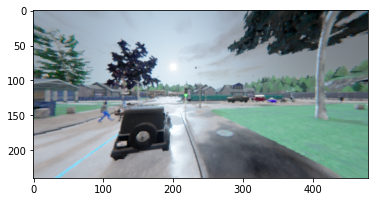

In [6]:
plt.imshow(step_data['wide_rgb_0'])

## 2. Waypoints computation

### 2.1 Tools for transformations

In [7]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Location(x={}, y={}, z={})".format(self.x, self.y, self.z)

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return "Rotation(pitch={}, yaw={}, roll={})".format(self.pitch, self.yaw, self.roll)

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Transform({}, {})".format(self.location, self.rotation)

In [8]:
PIXELS_PER_METER = 4
PIXELS_AHEAD_VEHICLE = 80

BACKGROUND = [238, 238, 236]

COLORS = [
        (102, 102, 102),
        (253, 253, 17),
        (255, 64, 64),
        (204, 6, 5),
        (0, 0, 142),
        (220, 20, 60),
        (255,0,0),
        (0,255,0),
        (0,0,0),
        (255,255,255),
        (0,255,128),
        (0,128,255),
        ]

SEM_COLORS = {
    4 : (220, 20, 60),
    5 : (153, 153, 153),
    6 : (157, 234, 50),
    7 : (128, 64, 128),
    8 : (244, 35, 232),
    10: (0, 0, 142),
    18: (220, 220, 0),
}

def viz_bv(birdview, no_show=[], num_channels=10):
    h, w = birdview.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[...] = BACKGROUND

    for i in range(num_channels):
        if i in no_show:
            continue
        canvas[birdview[:,:,i] > 0] = COLORS[i]

    return canvas

def viz_sem(sem, labels=[4,6,7,10,18]):
    canvas = np.zeros(sem.shape+(3,), dtype=np.uint8)
    for label in labels:
        canvas[sem==label] = SEM_COLORS[label]
    return canvas

def viz_obs(rgb, yaw, speed, cmd=None, lbl=None, sem=None, tls=None, text_args=(cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)):
    """
    0 road
    1 lane
    2 stop signs
    3 red light
    4 vehicle
    5 pedestrian
    6-11 waypoints
    """
    canvas = np.array(rgb[...,::-1])
    if lbl is not None:
        ori_x, ori_y = np.cos(yaw), np.sin(yaw)
        H = canvas.shape[0]
        lbl = viz_bv(lbl, num_channels=12)
        h, w = lbl.shape[:2]
        cv2.arrowedLine(lbl, (w//2,h//2), (w//2+int(ori_x*10),h//2+int(ori_y*10)), (255,128,0), 3)
        canvas = np.concatenate([canvas, cv2.resize(lbl, (H,H))], axis=1)

    # if sem is not None:
    #     sem_viz = visualize_semantic(sem)
    #     canvas = np.concatenate([sem_viz, canvas], axis=1)


    cv2.putText(canvas, f'speed: {speed}m/s', (4, 10), *text_args)
    if cmd is not None:
        cv2.putText(canvas, 'cmd: {}'.format({1:'left',2:'right',3:'straight',4:'follow',5:'change left',6:'change right'}.get(cmd)), (4, 30), *text_args)

    if tls is not None:
        cv2.putText(canvas, 'tls: {}'.format(tls), (4, 40), *text_args)

    return canvas


In [9]:
import glob, os
def clear_frames():
    folder='/storage2/mwildi/CBS2/Notebooks/frames'
    for file_name in glob.glob(folder+ "/*.png"):
        os.remove(file_name)
    print('Finished')
clear_frames()

Finished


### 2.2 Compute waypoints

In [15]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z, converter):
    '''pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector
    spot_in_front_of_vehicle = []
    new_pos = pos + 4 * ori
    spot_in_front_of_vehicle = converter.convert(np.array([new_pos]))
    if len(spot_in_front_of_vehicle) > 0:
        return spot_in_front_of_vehicle'''
    return [[240, 235]]

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=5, N_STEP=5):
    if decode_step(rep, REF_FRAME)['tls']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        return output, 'stop for traffic light'

    output = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP-1)*GAP), GAP):
        if len(output) == N_STEP:
            break

        pos = decode_step(rep, i)['ego_location']
        image_coords = converter.convert(np.array([[pos[0], pos[1], pos[2]]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        return output, 'only 1 waypoint visible in fwd camera view'

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output)), 'interpolated'

    return np.array(output), '5 waypoints in fwd camera view'

In [16]:
def loc_frame(rep, frame):
    # Extract world coordinates from dataset as well as rgb image and birdview
    step_data = decode_step(rep, frame)
    rgb=step_data['wide_rgb_0']
    lbl=step_data['lbl'].reshape(96,96,-1)
    #h, w = lbl.shape[:2]
    #cv2.arrowedLine(lbl, (w//2,h//2), (w//2+int(1*10),h//2+int(0*10)), (255,128,0), 3)
    pos = step_data['ego_location']
    rot = step_data['ego_rotation']
    spd = step_data['spd']
    cmd = step_data['cmd']
    tls = step_data['tls']
    cam_pos = step_data['cam_location']
    cam_rot = step_data['cam_rotation']
    
    # Waypoints driver perspective
    sensor_transform = Transform(Location(cam_pos[0], cam_pos[1], cam_pos[2]), Rotation(cam_rot[0], cam_rot[1], cam_rot[2]))
    converter = CoordinateConverter(sensor_transform, fov=120)
    image_coord_wp, text = get_waypoints(frame, pos[0], pos[1], pos[2], rot[0], rot[1], rot[2], converter, GAP, N_STEP)

    # Waypoints birdview
    locs = []
    for i in range(frame, (frame + N_STEP * GAP), GAP):
        loc = decode_step(rep,i)['loc'][:2]
        locs.append(loc)
    locs = np.array(locs)
    #dloc is the position of the next 5 waypoints w.r.t the current position
    dloc = (locs[:] - locs[0:1])*PIXELS_PER_METER - [0-MAP_SIZE/2,-MAP_SIZE/2]

    # Store computed waypoints
    tgt_rgb_loc = image_coord_wp[:, :2]
    #print(tgt_rgb_loc[0])
    tgt_bev_loc = dloc

    # Plot
    fbev, axbev = plt.subplots(figsize=(20,20))
    #axbev.imshow(viz_obs(rgb, rot[1], spd, cmd=int(cmd), lbl=lbl, tls=tls))
    axbev.imshow(viz_bv(lbl))
    for i in range(tgt_rgb_loc.shape[0]):   
        axbev.add_patch(Circle(tgt_bev_loc[i], 1, facecolor=(0,1,0,3/(i+3))))
    #axbev.axis('off')
    plt.savefig(folder + "/bev%d.png" % frame)
    plt.close()
    plt.rcParams.update({'font.size': 25})

    frgb, axrgb = plt.subplots(figsize=(20,20))
    axrgb.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    for i in range(tgt_rgb_loc.shape[0]):   
        axrgb.add_patch(Circle([ tgt_rgb_loc[i,0], tgt_rgb_loc[i,1] ], 4, facecolor=(0,1,0,3/(i+3))))
        axrgb.title.set_text(text)
    #axrgb.axis('off')
    plt.savefig(folder + "/rgb%d.png" % frame)
    plt.close()
    return tgt_rgb_loc, tgt_bev_loc

In [19]:
# Param
MAP_SIZE = 96
N_STEP = 5
GAP = 5
N_DATASET_CATEGORIES = len(data_dict_base.keys())+2
PIXELS_PER_METER = 4

# Waypoints driver perspective

np.set_printoptions(suppress=True)

# cam_x = 1.5
# cam_y = 0
# cam_z = 2.4
# cam_yaw = 0
# cam_roll = 0
# cam_pitch = 0

N = int((len(rep)-1)/N_DATASET_CATEGORIES -1)
print(f'Num frames: {N}')
folder='/storage2/mwildi/CBS2/Notebooks/frames'

all_wp = []
all_dloc = []
frame_range = range((N-1) - N_STEP*GAP + 1)
START_FRAME = 200
frame_range = range(START_FRAME, (N-1) - N_STEP*GAP + 1)
for frame in frame_range:
    tgt_rgb_loc, tgt_bev_loc = loc_frame(rep,frame)
    all_wp.append(tgt_rgb_loc)
    all_dloc.append(tgt_bev_loc)
print('Finished')

Num frames: 379


/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/mwildi/anaconda3/envs/cbs2/lib/python3.7/site-packages/i

Finished


In [20]:
#os.chdir(folder)
folder='/storage2/mwildi/CBS2/Notebooks/frames'
for i in frame_range:
    bev = cv2.imread(f'{folder}/bev{i}.png')
    rgb = cv2.imread(f'{folder}/rgb{i}.png')
    if rgb is not None and bev is not None:
        f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(40,20))
        rgb_ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        #lbl_ax.imshow(cv2.cvtColor(np.rot90(np.rot90(np.rot90(bev))), cv2.COLOR_RGB2BGR))
        lbl_ax.imshow(cv2.cvtColor(bev, cv2.COLOR_RGB2BGR))
        rgb_ax.axis('off')
        lbl_ax.axis('off')
        plt.savefig(folder + "/mix%d.png" % i)
        plt.close()

In [21]:
img_array=[]
for i in frame_range:
    img = cv2.imread(f'{folder}/mix{i}.png')
    if img is not None:
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
out = cv2.VideoWriter('projeceet.mp4',0x7634706d, 5, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()